In [4]:
from ultralytics import YOLO
import torch

model = YOLO('/kaggle/input/dsadadsad/best.pt')
model2 = YOLO('/kaggle/input/yolov8zhanibek/best(1).pt')

# Run inference
results1 = model('/kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-37-16.png')[0]
results2 = model2('/kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-37-16.png')[0]

# Extract predictions
boxes1 = results1.boxes.xyxy  # or .xywh
scores1 = results1.boxes.conf
labels1 = results1.boxes.cls

boxes2 = results2.boxes.xyxy
scores2 = results2.boxes.conf
labels2 = results2.boxes.cls

# Combine predictions
combined_boxes = torch.cat([boxes1, boxes2], dim=0)
combined_scores = torch.cat([scores1, scores2], dim=0)
combined_labels = torch.cat([labels1, labels2], dim=0)

# Optionally put into one result-like dict
combined_preds = {
    "boxes": combined_boxes,
    "scores": combined_scores,
    "labels": combined_labels
}



image 1/1 /kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-37-16.png: 576x832 7 petroglyphs, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 832)

image 1/1 /kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-37-16.png: 576x832 (no detections), 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 832)


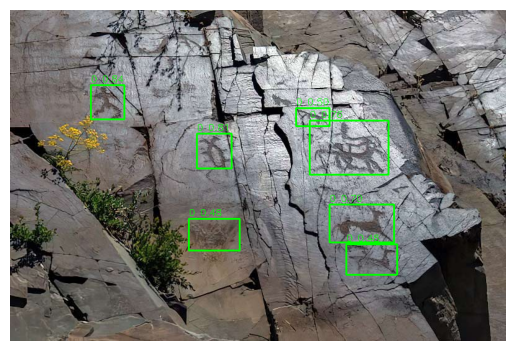

In [5]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('/kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-37-16.png')
for box, label, score in zip(combined_boxes, combined_labels, combined_scores):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(image, f'{int(label)} {score:.2f}', (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [7]:
import os
import cv2
import torch
import numpy as np
from PIL import Image, ImageEnhance
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Inputs
image_paths = [os.path.join('/kaggle/input/uts-hackathon/Dataset',i) for i in os.listdir('/kaggle/input/uts-hackathon/Dataset')] # Replace with your list
IMG_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Models
# These must be defined earlier
# model = YOLO('model.pt')
# model2 = YOLO('model2.pt')

# Create output directories
os.makedirs("output_bw", exist_ok=True)
os.makedirs("output_color", exist_ok=True)

# Main loop
for img_path in image_paths:
    print(f"Processing {img_path}...")

    img_pil = Image.open(img_path).convert("RGB")
    img_np = np.array(img_pil)

    # Run inference with both models
    results1 = model(img_path)[0]
    results2 = model2(img_path)[0]

    # Combine detections
    boxes1 = results1.boxes.xyxy if results1.boxes is not None else torch.empty((0, 4))
    boxes2 = results2.boxes.xyxy if results2.boxes is not None else torch.empty((0, 4))
    boxes = torch.cat([boxes1, boxes2], dim=0)

    # Init masks
    segmented_result = np.zeros((img_np.shape[0], img_np.shape[1]), dtype=np.uint8)       # BW
    segmented_color_result = np.zeros_like(img_np)                                        # RGB

    for i, bbox in enumerate(boxes):
        x1, y1, x2, y2 = map(int, bbox)

        # 1️⃣ Crop and enhance
        crop_img_np_rgb = img_np[y1:y2, x1:x2]
        pil_image = Image.fromarray(crop_img_np_rgb)
        enhanced_image = ImageEnhance.Color(pil_image).enhance(2.0)

        crop_pil_gray = enhanced_image.convert("L")
        crop_img_gray = np.array(crop_pil_gray)

        # 2️⃣ Threshold
        _, thresholded_img = cv2.threshold(crop_img_gray, 140, 255, cv2.THRESH_BINARY)

        # 2.5 Connected components cleanup
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresholded_img, connectivity=8)
        min_area = 10
        cleaned_mask = np.zeros_like(thresholded_img)
        for label in range(1, num_labels):
            if stats[label, cv2.CC_STAT_AREA] >= min_area:
                cleaned_mask[labels == label] = 255

        # 3️⃣ Add to global masks
        segmented_result[y1:y2, x1:x2] = np.maximum(segmented_result[y1:y2, x1:x2], cleaned_mask)

        # Color petroglyph only
        mask_bool = cleaned_mask.astype(bool)
        segmented_color_result[y1:y2, x1:x2][mask_bool] = crop_img_np_rgb[mask_bool]

        # (Optional) Model inference on the cropped area:
        # crop_tensor = T.ToTensor()(crop_pil_gray)
        # resized_crop = TF.resize(crop_tensor, [IMG_SIZE, IMG_SIZE])
        # input_batch = resized_crop.unsqueeze(0).to(DEVICE)
        # pred = model(input_batch)  # optional

    # Save masks
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    cv2.imwrite(f"output_bw/{base_name}_mask.png", segmented_result)
    cv2.imwrite(f"output_color/{base_name}_color.png", cv2.cvtColor(segmented_color_result, cv2.COLOR_RGB2BGR))

    print(f"Saved masks for {base_name}")



Processing /kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-39-40(2).png...

image 1/1 /kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-39-40(2).png: 576x832 2 petroglyphs, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 832)

image 1/1 /kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-39-40(2).png: 576x832 3 petroglyphs, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 832)
Saved masks for image_2024-10-26_17-39-40(2)
Processing /kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-37-17(2).png...

image 1/1 /kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-37-17(2).png: 576x832 11 petroglyphs, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 832)

image 1/1 /kaggle/input/uts-hackathon/Dataset/image_2024-10-26_17-37-17(2).png: 576x832 2 petroglyphs, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.4ms postprocess 

In [8]:
import zipfile
import os

def zip_folders(zip_name, folders):
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder in folders:
            for root, _, files in os.walk(folder):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, start=os.path.dirname(folder))
                    zipf.write(file_path, arcname)

# Usage
zip_folders('masks_output.zip', ['output_bw', 'output_color'])
print("✅ Created masks_output.zip with both folders.")


✅ Created masks_output.zip with both folders.
